# Calculating moist adiabats and dilute (entraining plume) adiabats with MetPy
This demo shows how to use the newly added functionality in MetPy that offers a convenient way to calculate moist adiabats.

## Acquiring the modified version of MetPy
The new functionality is not yet incorporated into the main branch of MetPy. Thus the first step is to download the modified version of MetPy. Run the following command in the directory where you want to store the modified MetPy:

```bash
git clone -b entrainment https://github.com/omiyawaki/MetPy
```

Next, we need to specify Python to load this version of MetPy over existing versions:

In [144]:
import sys
metpy_path='/glade/u/home/miyawaki/software/MetPy' # Change this directory to where you cloned the modified version of MetPy
sys.path.insert(1,'%s/src'%(metpy_path))

Now we are ready to load the modules as usual. Here we will use the following functions:

In [145]:
import numpy as np
from metpy.units import units
from metpy.calc import moist_lapse,parcel_profile
import matplotlib.pyplot as plt
%matplotlib inline

## Moist adiabats
To compute moist adiabats we need to define the initial parcel temperature.

In [146]:
t1=300*units.K # surface temperature

Below we define the pressure levels that we want to evaluate the moist adiabat. Here, I've set it to be the standard CMIP pressure levels between 1000 and 300 hPa.

In [147]:
pa=(1e2*np.array([1000,925,850,700,600,500,400,300]))*units.Pa

These are all we need for the moist adiabats.

### AMS moist adiabat
The [AMS moist adiabat](https://glossary.ametsoc.org/wiki/Adiabatic_lapse_rate) is a simplification of the pseudoadiabat, which assumes that all condensed water precipitates out of the parcel. Specifically, the AMS moist adiabat additionally assumes $r_v\ll1$ where $r_v$ is the saturation vapor mixing ratio. We can calculate the AMS moist adiabat as follows.

In [148]:
ams_moist_adiabat=moist_lapse(pa,t1,lapse_type='standard')
print(ams_moist_adiabat)

[300.0 297.47253353996354 294.6994380217984 288.1690727485031 282.7665790653971 276.0265466445446 267.04795865348086 253.75487192357863] kelvin


We can plot this temperature profile:

(1035.0, 265.0)

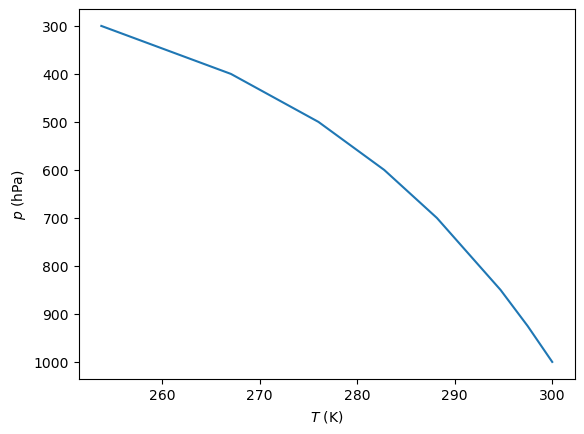

In [149]:
fig,ax=plt.subplots()
ax.plot(ams_moist_adiabat,1e-2*pa,label='AMS Adiabat')
ax.set_xlabel('$T$ (K)')
ax.set_ylabel('$p$ (hPa)')
ax.set_ylim(ax.get_ylim()[::-1])

### Pseudoadiabat
To compute the [pseudoadiabat](https://glossary.ametsoc.org/wiki/Pseudoadiabatic_lapse_rate), we change the lapse_type argument accordingly:

In [150]:
pseudoadiabat=moist_lapse(pa,t1,lapse_type='pseudoadiabatic')
print(pseudoadiabat)

[300.0 297.4945987436791 294.7444870478361 288.2638798031398 282.8989156391682 276.202733697518 267.2801075769228 254.06644669615565] kelvin


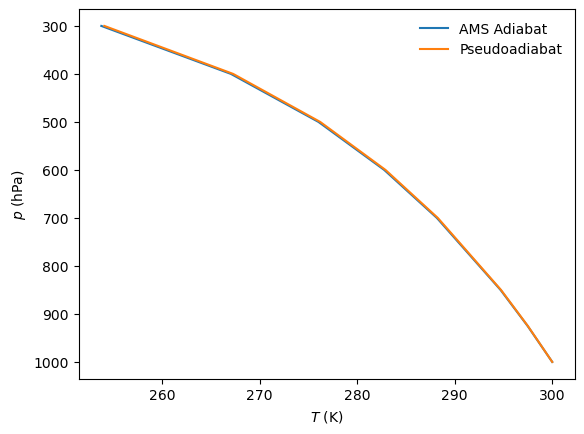

In [151]:
ax.plot(pseudoadiabat,1e-2*pa,label='Pseudoadiabat')
ax.legend(frameon=False)
fig

### Reversible moist adiabat
The [reversible moist adiabat](https://glossary.ametsoc.org/wiki/Reversible_moist-adiabatic_process) assumes all condensates stay in the parcel. To compute it using MetPy,

In [152]:
reversible=moist_lapse(pa,t1,lapse_type='reversible')
print(reversible)

[300.0 297.4945398114784 294.7445174664109 288.267902974603 282.9154257493355 276.2570473100615 267.44869622647735 254.6114144064029] kelvin


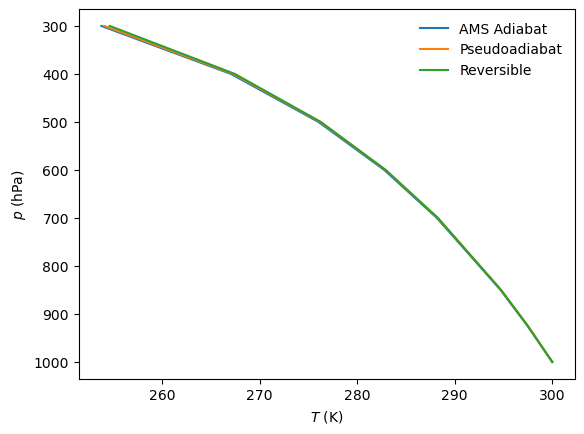

In [153]:
ax.plot(reversible,1e-2*pa,label='Reversible')
ax.legend(frameon=False)
fig

## Dry adiabat to LCL, moist adiabat above
Generally rising air parcels are initially subsaturated. In such cases, it is more appropriate to follow the dry adiabat up to the level of saturation, or the [lifting condensation level (LCL)](https://glossary.ametsoc.org/wiki/Lifting_condensation_level). The function parcel_profile computes this temperature profile.

To begin, we must specify the initial moisture content in the parcel. parcel_profile takes moisture in the form of dew point temperature. MetPy has functions that convert alternative quantities for moisture such as [relative humidity](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.dewpoint_from_relative_humidity.html) and [specific humidity](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.dewpoint_from_specific_humidity.html) to dew point temperature.

In [154]:
td=290*units.K # surface dew point temperature

Calculate the temperature profile of an initially subsaturated parcel as follows

In [155]:
subsaturated=parcel_profile(pa,t1,td,lapse_type='standard')
print(subsaturated)

[300.0 293.39145714174094 287.10310830489635 279.4857760916165 272.98867697346196 264.624969177309 253.1546948219009 236.41984930654863] kelvin


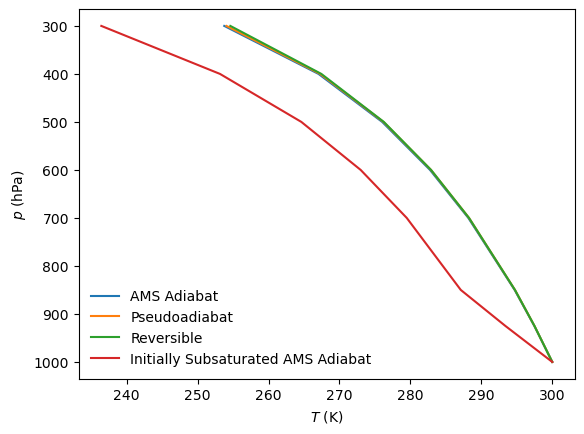

In [156]:
ax.plot(subsaturated,1e-2*pa,label='Initially Subsaturated AMS Adiabat')
ax.legend(frameon=False)
fig

# Entraining plumes
The moist adiabat assumes the rising parcel does not interact with its surrounding environment. Entraining plume models relax this assumption by including the effect of turbulent air exchange between the parcel and its environment.

## Singh and O'Gorman (2013)
One example of an entraining plume model is [Singh and O'Gorman (2013)](https://agupubs-onlinelibrary-wiley-com.cuucar.idm.oclc.org/doi/10.1002/grl.50796). This model is referred to as the zero-buoyancy plume model because it assumes the temperature of the rising parcel is equal to the surrounding air at a given height (i.e., the parcel and environment have equal buoyancy ignoring the density differences due to differences in moisture).

The model requires as inputs the vertical profile of the entrainment rate and the relative humidity of the surrounding environment. In the paper, they assume 
1. the entrainment rate $\epsilon$ decreases inversely with height $z$, i.e.
$$ \epsilon(z) = \hat{\epsilon} /z $$
2. the environmental relative humidity is vertically uniform.

### Technical note on implementation in MetPy
Since moist_lapse integrates in pressure instead of height, the entrainment profile is inversely proportional to the pseudoheight $z_p$, i.e. $\epsilon(p)=\hat{\epsilon}/z_p$ where
$$z_p=-H\log(p/p_0)$$
where $H=RT_0/g$ is a scale height and $p_0$ is a reference pressure. Here, $T_0$ and $p_0$ correspond to the initial temperature and pressure of the parcel at LCL.

### Example
To compute the Singh and O'Gorman (2013) entraining plume, we specify the input parameters and call moist_lapse or parcel_profile with the corresponding lapse_type:

In [157]:
ep0=0.75
rh0=0.8
so13=parcel_profile(pa,t1,td,lapse_type='so13',params={'ep0':ep0,'rh0':rh0})
print(so13)

[300.0 293.39145714174094 286.3882695305332 275.20220057684895 267.5215457380874 257.905238007138 245.05808843180128 227.34697936485384] kelvin


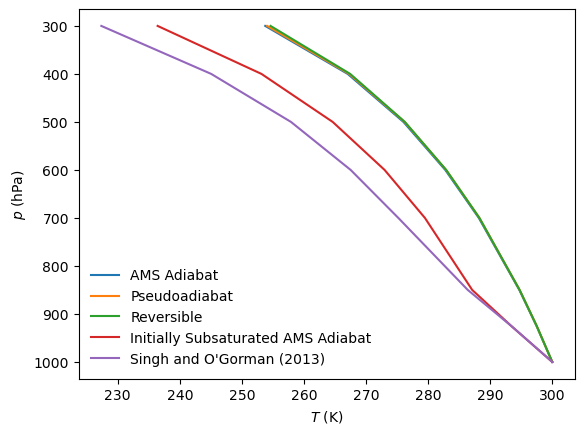

In [158]:
ax.plot(so13,1e-2*pa,label="Singh and O'Gorman (2013)")
ax.legend(frameon=False)
fig

## Romps (2014)
Another example of an entraining plume model is [Romps (2014)](https://journals-ametsoc-org.cuucar.idm.oclc.org/view/journals/clim/27/19/jcli-d-14-00255.1.xml). This model considers not only the drying effect of mixing surrounding air into the rising parcel (entrainment) but the moistening effect of mixing the parcel air out to the surroundings (detrainment). By doing so the model predicts not only the vertical temperature but also the humidity profile of the surrounding air. Recall that the Singh and O'Gorman (2013) model takes the humidity profile as an input.

This model requires as inputs the vertical profile of entrainment and detrainment rates. Equal entrainment and detrainment rates implies a uniform vertical mass flux, which is assumed in Romps (2014) in the lower troposphere. For simplicity, we start by assuming vertically constant and equal entrainment and detrainment rates through the entire column:

In [159]:
ep=0.5e-3 # fractional entrainment rate [m**-2]
de=ep     # fractional detrainment rate [m**-2]
r14=parcel_profile(pa,t1,td,lapse_type='r14',params={'ep':ep,'de':de})
print(r14)

[300.0 293.39145714174094 286.8417989194509 276.07425668852136 267.1004381037151 255.98547082300283 241.8377557403658 223.5254415576419] kelvin


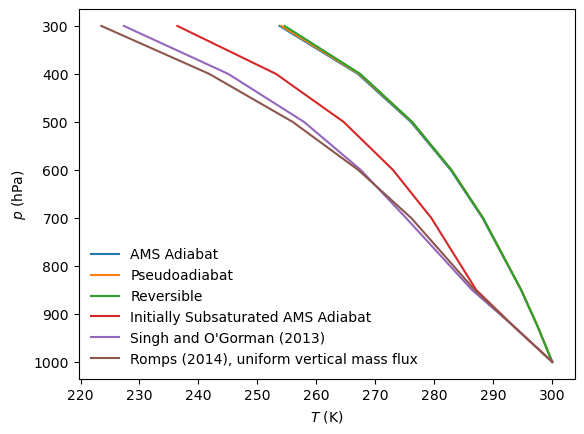

In [160]:
ax.plot(r14,1e-2*pa,label='Romps (2014), uniform vertical mass flux')
ax.legend(frameon=False)
fig

However, the script also works for vertically-varying profiles of entrainment and detrainment rates:

In [161]:
pa_r14=pa.data # for simplicity use same pressure levels as output levels to define entrainment and detrainment rate profiles
ep=0.5e-3*np.ones_like(pa_r14) # keep entrainment rate profile constant with height
de=np.linspace(ep[0],1.5e-3,len(pa_r14)) # for simplicity increase detrainment linearly (for pedagogical purposes only; the detrainment profile in the paper is more complicated than this)
r14v=parcel_profile(pa,t1,td,lapse_type='r14',params={'ep':ep,'de':de,'pa':pa_r14})
print(r14v)

[300.0 293.39145714174094 287.0123181832683 278.2177800669178 270.671522320217 260.97985070068006 247.9812767430812 230.09234341512152] kelvin


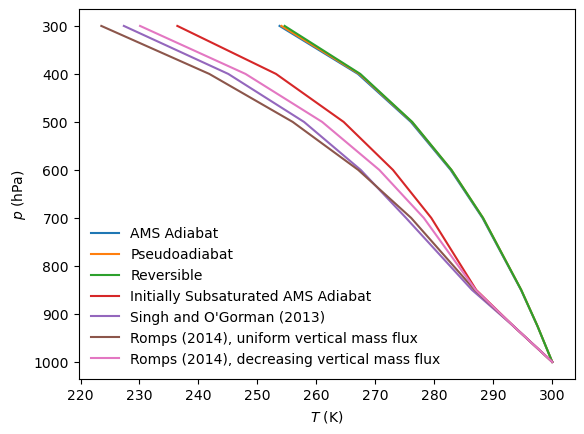

In [162]:
ax.plot(r14v,1e-2*pa,label='Romps (2014), decreasing vertical mass flux')
ax.legend(frameon=False)
fig